In [2]:
from __future__ import division
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body


%matplotlib inline

Using TensorFlow backend.


计算对象的可能性： 

a = np.random.randn(19x19,5,1) #p_c 
b = np.random.randn(19x19,5,80) #c_1 ~ c_80 
c = a * b #计算后的维度将会是(19x19,5,80) 
对于每个锚框，需要找到：

对分类的预测的概率拥有最大值的锚框的下标（查看中文文档），需要注意的是我们需要选择的轴，我们可以试着使用axis=-1。

对应的最大值的锚框（查看中文文档），需要注意的是我们需要选择的轴，我们可以试着使用axis=-1。

根据阈值来创建掩码，比如执行下列操作：[0.9, 0.3, 0.4, 0.5, 0.1] < 0.4，返回的是[False, True, False, False, True]，对于我们要保留的锚框，对应的掩码应该为True或者1.

使用TensorFlow来对box_class_scores、boxes、box_classes进行掩码操作以过滤出我们想要的锚框。


In [3]:
def yolo_filter_boxes(box_confidence , boxes, box_class_probs, threshold = 0.6):
    """
    通过阈值来过滤对象和分类的置信度。

    参数：
        box_confidence  - tensor类型，维度为（19,19,5,1）,包含19x19单元格中每个单元格预测的5个锚框中的所有的锚框的pc （一些对象的置信概率）。
        boxes - tensor类型，维度为(19,19,5,4)，包含了所有的锚框的（px,py,ph,pw ）。
        box_class_probs - tensor类型，维度为(19,19,5,80)，包含了所有单元格中所有锚框的所有对象( c1,c2,c3，···，c80 )检测的概率。
        threshold - 实数，阈值，如果分类预测的概率高于它，那么这个分类预测的概率就会被保留。

    返回：
        scores - tensor 类型，维度为(None,)，包含了保留了的锚框的分类概率。
        boxes - tensor 类型，维度为(None,4)，包含了保留了的锚框的(b_x, b_y, b_h, b_w)
        classess - tensor 类型，维度为(None,)，包含了保留了的锚框的索引

    注意："None"是因为你不知道所选框的确切数量，因为它取决于阈值。
          比如：如果有10个锚框，scores的实际输出大小将是（10,）
    """

    #第一步：计算锚框的得分
    box_scores  = box_confidence * box_class_probs    #(19,19,5,80)
    #第二步：找到最大值的锚框的下标以及对应的最大值的锚框的分数
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    #第三步：根据阈值创建掩码
    filtering_mask = (box_class_scores >= threshold)

    #对scores, boxes 以及 classes使用掩码
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)

    return scores , boxes , classes

In [4]:
with tf.Session() as test_a:
    box_confidence = tf.random_normal([19,19,5,1], mean=1, stddev=4, seed=1)
    boxes = tf.random_normal([19,19,5,4],  mean=1, stddev=4, seed=1)
    box_class_probs = tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))

    test_a.close()

scores[2] = 10.750582
boxes[2] = [ 8.426533   3.2713668 -0.5313436 -4.9413733]
classes[2] = 7
scores.shape = (1783,)
boxes.shape = (?, 4)
classes.shape = (?,)


# 非最大值抑制使用了一个非常重要的功能，叫做交并比（Intersection over Union (IoU)） 



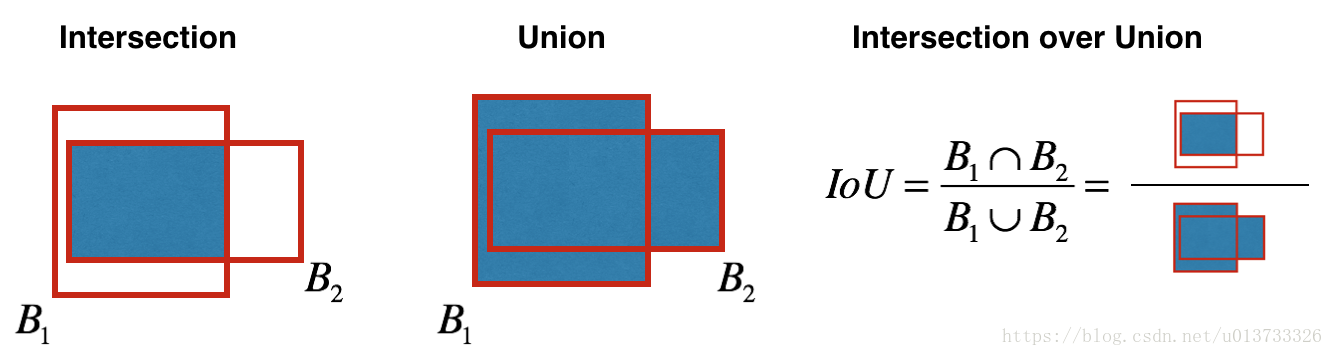
现在我们要实现交并比函数iou()，步骤如下：

在这里，我们要使用左上和右下角来定义方框(x1,y1,x2,y2)而不是使用中点+宽高的方式定义。

要计算矩形的面积我们需要用高度（y2−y1）乘以 （x2−x1）

我们还需要找到两个锚框的交点的坐标（xi1,yi1,xi2,yi2）

xi1 = 两个锚框的x1坐标的最大值
yi1 = 两个锚框的y1坐标的最大值
xi2 = 两个锚框的x2坐标的最小值
yi2 = 两个锚框的y2坐标的最小值
为了计算相交的区域，我们需要确定相交的区域的宽、高均为正数，否则就为0，我们可以使用max(height, 0) 与 max(width, 0)来完成。

在代码中，我们为了方便把图片的左上角定为(0,0),右上角为(1,0)，左下角为(0,1)，右下角为(1,1)。

In [5]:
def iou(box1, box2):
    """
    实现两个锚框的交并比的计算

    参数：
        box1 - 第一个锚框，元组类型，(x1, y1, x2, y2)
        box2 - 第二个锚框，元组类型，(x1, y1, x2, y2)

    返回：
        iou - 实数，交并比。
    """
    #计算相交的区域的面积
    xi1 = np.maximum(box1[0], box2[0])
    yi1 = np.maximum(box1[1], box2[1])
    xi2 = np.minimum(box1[2], box2[2])
    yi2 = np.minimum(box1[3], box2[3])
    inter_area = (xi2-xi1)*(yi2-yi1)

    #计算并集，公式为：Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2]-box1[0])*(box1[3]-box1[1])
    box2_area = (box2[2]-box2[0])*(box2[3]-box2[1])
    union_area = box1_area + box2_area - inter_area
    #计算交并比
    iou = inter_area / union_area

    return iou

In [6]:
box1=(2,1,4,3)
box2=(1,2,3,4)
Iou=iou(box1,box2)
print("iou=" + str(Iou))

iou=0.14285714285714285


In [7]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes=10, iou_threshold=0.5):
    """
    为锚框实现非最大值抑制（ Non-max suppression (NMS)）

    参数：
        scores - tensor类型，维度为(None,)，yolo_filter_boxes()的输出
        boxes - tensor类型，维度为(None,4)，yolo_filter_boxes()的输出，已缩放到图像大小（见下文）
        classes - tensor类型，维度为(None,)，yolo_filter_boxes()的输出
        max_boxes - 整数，预测的锚框数量的最大值
        iou_threshold - 实数，交并比阈值。

    返回：
        scores - tensor类型，维度为(,None)，每个锚框的预测的可能值
        boxes - tensor类型，维度为(4,None)，预测的锚框的坐标
        classes - tensor类型，维度为(,None)，每个锚框的预测的分类

    注意："None"是明显小于max_boxes的，这个函数也会改变scores、boxes、classes的维度，这会为下一步操作提供方便。

    """
    max_boxes_tensor = K.variable(max_boxes,dtype="int32") #用于tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) #初始化变量max_boxes_tensor

    #使用使用tf.image.non_max_suppression()来获取与我们保留的框相对应的索引列表
    nms_indices = tf.image.non_max_suppression(boxes, scores,max_boxes,iou_threshold)

    #使用K.gather()来选择保留的锚框
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)

    return scores, boxes, classes

In [8]:
with tf.Session() as test_b:
    scores = tf.random.normal([54],mean=1,stddev=4,seed=1)
    boxes = tf.random.normal([54,4],mean=1,stddev=4,seed=1)
    classes = tf.random.normal([54],mean=1,stddev=4,seed=1)
    scores,boxes,classes=yolo_non_max_suppression(scores,boxes,classes,10)
    
    print("scores[2]="+ str(scores[2].eval()))
    print("boxes[2]="+ str(boxes[2].eval()))
    print("classes[2]="+ str(classes[2].eval()))
    print("scores.shape=" + str(scores.eval().shape))
    print("boxes.shape=" + str(boxes.shape))
    print("classes.shape=" + str(classes.shape))
    test_b.close()

scores[2]=6.938395
boxes[2]=[-5.299932    3.1379814   4.450367    0.95942086]
classes[2]=-2.2452729
scores.shape=(10,)
boxes.shape=(?, 4)
classes.shape=(?,)


In [9]:
def yolo_eval(yolo_outputs,image_shape=(720.,1280.),max_boxes=10,scores_threshold=.5,iou_threshold=.4):
    """
    将YOLO编码的输出（很多锚框）转换为预测框以及它们的分数，框坐标和类。
    
    参数：
        yolo_outputs - 编码模型的输出（对于维度为（608,608,3）的图片），包含4个tensors类型的变量：
                        box_confidence ： tensor类型，维度为(None, 19, 19, 5, 1)
                        box_xy         ： tensor类型，维度为(None, 19, 19, 5, 2)
                        box_wh         ： tensor类型，维度为(None, 19, 19, 5, 2)
                        box_class_probs： tensor类型，维度为(None, 19, 19, 5, 80)
        image_shape - tensor类型，维度为（2,），包含了输入的图像的维度，这里是(608.,608.)
        max_boxes - 整数，预测的锚框数量的最大值
        score_threshold - 实数，可能性阈值。
        iou_threshold - 实数，交并比阈值。

    返回：
        scores - tensor类型，维度为(,None)，每个锚框的预测的可能值
        boxes - tensor类型，维度为(4,None)，预测的锚框的坐标
        classes - tensor类型，维度为(,None)，每个锚框的预测的分类
    """
    # 获取yolo模型的输出
    box_confidence,box_xy,box_wh,box_class_probs=yolo_outputs
    # 中心点转换为边角
    boxes=yolo_boxes_to_corners(box_xy,box_wh)
    # 可信度分值过滤
    scores,boxes,classes = yolo_filter_boxes(box_confidence,boxes,box_class_probs,scores_threshold)
    # 缩放锚框，使之符合图片大小
    boxes=scale_boxes(boxes,image_shape)
    # 非最大值抑制
    scores,boxes,classes = yolo_non_max_suppression(scores,boxes,classes,max_boxes,iou_threshold)
    
    return scores,boxes,classes

In [10]:
with tf.Session() as test_b:
    yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


In [11]:
# 创建会话
sess = K.get_session()
# 读取数据
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
# 设定图像维度（H,W）
image_shape = (720.,1280.)

In [13]:
# 载入模型
yolo_model = load_model("/home/wang/PycharmProjects/keras-yolo3-master/model_data/yolo.h5")

/home/wang/.local/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [14]:
# 模型摘要
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
zero_paddi

In [16]:
# 将模型输出转换为边界框
# yolo_model的输出是（m,19,19,5,85）的tensor变量，需要进行转换
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

AttributeError: 'list' object has no attribute 'dtype'

In [56]:
# 过滤锚框，选出最佳
image_shape = (333.,500.)
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

In [57]:
def predict(sess, image_file, is_show_info=True, is_plot=True):
    """
    运行存储在sess的计算图以预测image_file的边界框，打印出预测的图与信息。

    参数：
        sess - 包含了YOLO计算图的TensorFlow/Keras的会话。
        image_file - 存储在images文件夹下的图片名称
    返回：
        out_scores - tensor类型，维度为(None,)，锚框的预测的可能值。
        out_boxes - tensor类型，维度为(None,4)，包含了锚框位置信息。
        out_classes - tensor类型，维度为(None,)，锚框的预测的分类索引。 
    """
    #图像预处理
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))

    #运行会话并在feed_dict中选择正确的占位符.
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict = {yolo_model.input:image_data, K.learning_phase(): 0})

    #打印预测信息
    if is_show_info:
        print("在" + str(image_file) + "中找到了" + str(len(out_boxes)) + "个锚框。")

    #指定要绘制的边界框的颜色
    colors = generate_colors(class_names)

    #在图中绘制边界框
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)

    #保存已经绘制了边界框的图
    image.save(os.path.join("out", image_file), quality=100)

    #打印出已经绘制了边界框的图
    if is_plot:
        output_image = scipy.misc.imread(os.path.join("out", image_file))
        plt.imshow(output_image)

    return out_scores, out_boxes, out_classes

在1112.jpg中找到了0个锚框。


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


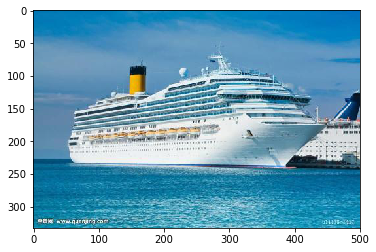

In [61]:
out_scores, out_boxes, out_classes = predict(sess, "1112.jpg")

当前文件：1111.jpg
在1111.jpg中找到了1个锚框。
boat 0.87 (166, 168) (443, 279)
当前文件：1112.jpg


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


在1112.jpg中找到了0个锚框。
当前文件：1113.jpg
在1113.jpg中找到了1个锚框。
boat 0.85 (101, 42) (399, 283)
当前文件：1114.jpg
在1114.jpg中找到了1个锚框。
boat 0.81 (142, 38) (358, 265)
当前文件：1115.jpg
在1115.jpg中找到了3个锚框。
boat 0.68 (4, 62) (302, 123)
boat 0.74 (232, 24) (478, 70)
boat 0.83 (36, 167) (366, 269)
当前文件：1116.jpg
在1116.jpg中找到了3个锚框。
boat 0.56 (15, 105) (281, 326)
boat 0.65 (305, 71) (404, 93)
boat 0.78 (232, 101) (492, 270)
当前文件：1117.jpg
在1117.jpg中找到了1个锚框。
boat 0.83 (66, 79) (452, 253)
当前文件：1118.jpg
在1118.jpg中找到了1个锚框。
boat 0.76 (154, 87) (344, 243)
当前文件：1119.jpg
在1119.jpg中找到了1个锚框。
boat 0.78 (165, 120) (323, 274)
绘制完成！


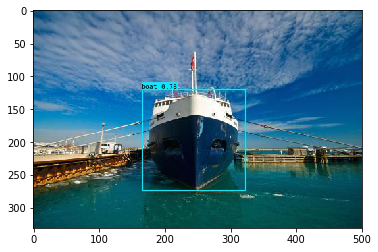

In [59]:
for i in range(1111,1120):
     #计算需要在前面填充几个0
    num_fill = int( len("0000") - len(str(1))) + 1
    #对索引进行填充
    filename = str(i).zfill(num_fill) + ".jpg"
    print("当前文件：" + str(filename))

    #开始绘制，不打印信息，不绘制图
    out_scores, out_boxes, out_classes = predict(sess, filename,is_show_info=False,is_plot=True)



print("绘制完成！")